In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import torch

from torchvision import transforms
from rsl_depth_completion.diffusion.utils import set_seed

from pathlib import Path
import shutil
import numpy as np
from transformers import CLIPModel, CLIPProcessor

from kbnet import data_utils
import yaml
import argparse



%matplotlib inline

2023-04-28 10:47:38.848391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 10:47:38.929169: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-28 10:47:39.377928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-28 10:47:39.377977: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

# config

In [2]:
input_channels = 1
timesteps = 200
# timesteps = 30

seed = 100
set_seed(seed)

run_name='test'
results_folder = Path("./imagen_results") / run_name
shutil.rmtree(results_folder, ignore_errors=True)
results_folder.mkdir(parents=True,exist_ok = True)

input_imgsize = (352, 1216)
input_channels = 1
batch_size = 2

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device='cpu'


In [3]:

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_name = 'overfit_img_img_kitti'
dir_path = f"./training_{exp_name}"
training_dir = os.makedirs(dir_path, exist_ok=True)

# model

In [4]:

extractor_model_ref = "openai/clip-vit-base-patch32"
extractor_model = CLIPModel.from_pretrained(extractor_model_ref)
extractor_processor = CLIPProcessor.from_pretrained(extractor_model_ref)

In [5]:
path_to_project_dir='/media/master/wext/msc_studies/second_semester/research_project/project'
base_kitti_dataset_dir='/media/master/wext/cv_data/kitti-full'
# raise RuntimeError("please set the variables above")

In [6]:
ds_config_str = open(f"{path_to_project_dir}/rsl_depth_completion/configs/data/kitti_custom.yaml").read()
ds_config_str=ds_config_str.replace("${data_dir}", base_kitti_dataset_dir)
ds_config = argparse.Namespace(**yaml.safe_load(ds_config_str)['ds_config'])
ds_config.use_pose = "photo" in ds_config.train_mode
ds_config.result = ds_config.result_dir
ds_config.use_rgb = ("rgb" in ds_config.input) or ds_config.use_pose
ds_config.use_d = "d" in ds_config.input
ds_config.use_g = "g" in ds_config.input
val_image_paths = data_utils.read_paths(ds_config.val_image_path)
val_sparse_depth_paths = data_utils.read_paths(
    ds_config.val_sparse_depth_path
)
val_intrinsics_paths = data_utils.read_paths(
    ds_config.val_intrinsics_path
)
val_ground_truth_paths = data_utils.read_paths(
    ds_config.val_ground_truth_path
)

In [7]:
import cv2
from rsl_depth_completion.conditional_diffusion import utils
from rsl_depth_completion.data.kitti.kitti_dataset import CustomKittiDCDataset


class MinimagenDatasetCustom(CustomKittiDCDataset):
    def __init__(self, include_cond_image=False, sdm_transform=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.include_cond_image = include_cond_image
        self.default_transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.sdm_transform = sdm_transform or self.default_transform
        self.max_depth = 80

    def __getitem__(self, idx):
        items = super().__getitem__(idx)
        sparse_dm = items["d"]
        sparse_dm /= self.max_depth

        interpolated_sparse_dm = torch.from_numpy(
            utils.interpolate_sparse_depth(sparse_dm.numpy())
        )

        rgb_image = items["img"]

        rgb_pixel_values = self.extract_img_features(rgb_image)
        sdm_pixel_values = self.extract_img_features(cv2.cvtColor(sparse_dm.squeeze().numpy(), cv2.COLOR_GRAY2RGB))
        rgb_embed = extractor_model.get_image_features(pixel_values=rgb_pixel_values)
        sdm_embed = extractor_model.get_image_features(pixel_values=sdm_pixel_values)

        sample = {
            "perturbed_sdm": interpolated_sparse_dm.detach(),
            "rgb_embed": rgb_embed.detach(),
            "sdm_embed": sdm_embed.detach(),
            "rgb_image": (rgb_image / 255).detach(),
        }
        return sample

    def extract_img_features(self, cond_image):
        return extractor_processor(
            images=torch.stack(
                [
                    torch.from_numpy(np.array(cond_image)),
                ]
            ),
            return_tensors="pt",
        ).pixel_values


ds = MinimagenDatasetCustom(
    ds_config=ds_config,
    image_paths=val_image_paths,
    sparse_depth_paths=val_sparse_depth_paths,
    intrinsics_paths=val_intrinsics_paths,
    ground_truth_paths=val_ground_truth_paths,
    include_cond_image=True,
)
x = ds[0]
x["perturbed_sdm"].shape, x["rgb_embed"].shape, x["sdm_embed"].shape, x["rgb_image"].shape


(torch.Size([1, 352, 1216]),
 torch.Size([1, 512]),
 torch.Size([1, 512]),
 torch.Size([3, 352, 1216]))

In [8]:
from minimagen.training import MinimagenCollator


ds_subset = torch.utils.data.Subset(ds, range(0, len(ds)//2))
train_size = int(0.8 * len(ds_subset))
test_size = len(ds_subset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(
    ds_subset,
    [train_size, test_size]
)
BATCH_SIZE=4
NUM_WORKERS=min(20, BATCH_SIZE)
dl_opts = {
    "batch_size": BATCH_SIZE,
    "num_workers": NUM_WORKERS,
    "drop_last": True,
    "collate_fn": MinimagenCollator(device),
}
train_dataloader = torch.utils.data.DataLoader(train_dataset, **dl_opts, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, **dl_opts, shuffle=True)


In [9]:
len(train_dataloader), len(valid_dataloader)

(100, 25)

In [10]:
x_train=next(iter(train_dataloader))
x_val=next(iter(valid_dataloader))

In [11]:
import gc

gc.collect()
torch.cuda.empty_cache()

# from minimagen.Imagen import Imagen
# from minimagen.Unet import Unet
# from rsl_depth_completion.conditional_diffusion.imagen import Imagen
# from rsl_depth_completion.conditional_diffusion.Unet import Unet
from imagen_pytorch import Unet, Imagen

# unet_super_res = Unet(
#     dim=64,
#     dim_mults=[1, 1, 2, 2, 4, 4],
#     channels=1,
#     channels_out=None,
#     cond_dim=None,
#     text_embed_dim=512,
#     num_resnet_blocks=2,
#     layer_attns=[False, False, False, False, False, True],
#     layer_cross_attns=[False, False, False, False, False, True],
#     attn_heads=8,
#     lowres_cond=False,
#     memory_efficient=True,
#     attend_at_middle=False,
# )
unet_base = Unet(
    dim=64,
    dim_mults=[1, 1, 2, 2, 4, 4],
    channels=1,
    channels_out=None,
    text_embed_dim=512,
    num_resnet_blocks=2,
    layer_attns=[False, False, False, False, False, True],
    layer_cross_attns=[False, False, False, False, False, True],
    attn_heads=8,
    lowres_cond=False,
    memory_efficient=False,
    attend_at_middle=False,
    cond_dim=None,
    cond_images_channels=3,
)
unets = [unet_base]

imagen = Imagen(
    unets=unets,
    text_embed_dim=512,
    channels=1,
    timesteps=300,
    loss_type="l2",
    lowres_sample_noise_level=0.2,
    dynamic_thresholding_percentile=0.9,
    only_train_unet_number=None,
    image_sizes=[128],
    text_encoder_name="google/t5-v1_1-base",
    auto_normalize_img=True,
    cond_drop_prob=0.1,
    condition_on_text=True,
)

unet_base.to(device)
imagen.to(device)
print("Number of parameters in model", sum(p.numel() for p in imagen.parameters() if p.requires_grad))

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/
Number of parameters in model 30035586


In [12]:
# restore_model = True
restore_model = False
if restore_model:
    imagen.load_state_dict(torch.load("./sdm_cond_126.pt"))

In [21]:
import torch.optim as optim
OPTIM_LR = 5e-7
optimizer = optim.Adam(imagen.parameters(), lr=OPTIM_LR)

In [14]:
train_unet_losses={"base": [], "super": []}
val_unet_losses={"base": [], "super": []}

In [15]:
perturbed_sdm=x_train['perturbed_sdm'][:,:,50:50+256,400:400+256]
rgb_img=x_train['rgb_image']
sdm_embed=x_train['sdm_embed']

In [16]:
perturbed_sdm.min(),perturbed_sdm.max(), rgb_img.min(), rgb_img.max()

(tensor(0.0938), tensor(0.9742), tensor(0.), tensor(1.))

In [16]:
# plt.imshow((x[cond_img].squeeze(0).permute(1,2,0) / 255).cpu().numpy())
# plt.imshow((x[input_img].permute(1,2,0) / 255)[50:50+256,400:400+256].cpu().numpy())

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 43	{'loss': 4.029207078740001}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 45	{'loss': 3.73529433645308}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 47	{'loss': 3.623169517144561}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 49	{'loss': 3.341586586087942}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 51	{'loss': 3.2995434049516916}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 53	{'loss': 3.2326007951050997}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 55	{'loss': 3.0034585893154144}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 57	{'loss': 2.8724058642983437}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 59	{'loss': 2.872154174372554}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 61	{'loss': 2.8194949002936482}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 63	{'loss': 2.7769924961030483}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 65	{'loss': 2.5866611525416374}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 67	{'loss': 2.5930973887443542}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 69	{'loss': 2.612425085157156}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 71	{'loss': 2.5640756841748953}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 73	{'loss': 2.5956938536837697}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 75	{'loss': 2.4347820207476616}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 77	{'loss': 2.6063851406797767}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 79	{'loss': 2.50918828882277}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 81	{'loss': 2.433270583860576}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 83	{'loss': 2.420109105296433}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

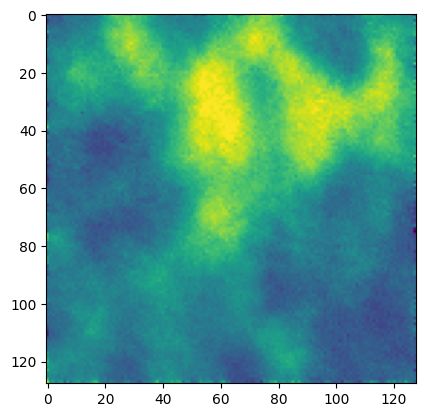

In [22]:
from torchvision.utils import save_image
from tqdm.auto import tqdm

num_epochs=21
progress_bar = tqdm(total=num_epochs, disable=False)
test_dir='./samples_sdm_rgb_cond'
# !rm -rf {test_dir}
os.makedirs(test_dir, exist_ok=True)

# plt.imshow(images[0].permute(1, 2, 0).cpu().detach().numpy())
# plt.savefig(f"{test_dir}/input.png")

start_epoch_scaler = 2
start_epoch = num_epochs*start_epoch_scaler
final_epoch = num_epochs*(start_epoch_scaler+2)
for epoch in (range(start_epoch, final_epoch)):
    progress_bar.set_description(f"Epoch {epoch}")
    optimizer.zero_grad()
    running_loss = {"loss" : 0}
    with torch.autocast(device):
        for batch in tqdm(train_dataloader):
            perturbed_sdm=batch['perturbed_sdm'][:,:,50:50+256,400:400+256].to(device)
            rgb_img=batch['rgb_image'].to(device)
            sdm_embed=batch['sdm_embed'].to(device)
            for i in range(1,2):
                loss = imagen(perturbed_sdm, 
                            text_embeds=sdm_embed,
                            cond_images=rgb_img,
                            unet_number=i)
                # loss=forward_out["loss"]
                loss.backward()
                running_loss["loss"] += loss.item()
            optimizer.step()

    progress_bar.update(1)

    if (epoch-1) % 2 == 0:
        print(f'Epoch: {epoch}\t{running_loss}')
        train_unet_losses["base"].append(running_loss["loss"])
        
        progress_bar.set_postfix(**running_loss)

        with torch.no_grad():
            samples = imagen.sample(
                text_embeds=sdm_embed,
                cond_images=rgb_img,
                cond_scale=1.0,
                # cond_images=cond_images,
                stop_at_unet_number=1,
            )

        plt.imshow(samples[0].permute(1, 2, 0).cpu().detach().numpy())
        plt.savefig(f"{test_dir}/{epoch:04d}.png")
torch.save(imagen.state_dict(), f"./sdm_rgb_cond_{final_epoch}.pt")

In [ ]:
plt.imshow(samples[0].permute(1, 2, 0).cpu().detach().numpy())

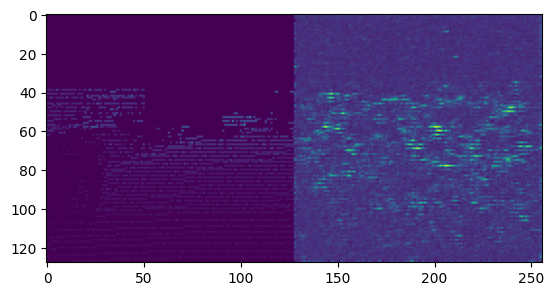

In [42]:
concatenated_img_and_denoised = torch.concatenate([transforms.Resize((128,128))(images[1]), samples[0]], dim=2)
plt.imshow(concatenated_img_and_denoised.permute(1, 2, 0).cpu().detach().numpy())